<a href="https://colab.research.google.com/github/Tarsis1/livro-receitas/blob/master/Reconhecimento_de_imgs_por_TranferLearn_Tarsis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf


import numpy as np
import tensorflow as tf
import keras

# DEFININDO PARAMETROS E CARREGANDO DATASET

In [ ]:
_URL = 'https://drive.google.com/uc?export=download&id=1w7bHDQ14d1y-pb-31u5kuMLNGvVQLHyo'
path_to_zip = tf.keras.utils.get_file('Dataset2.1.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'Dataset2.1')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

6330007/6330007 [==============================] - 0s 0us/step
Found 140 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 60 files belonging to 2 classes.


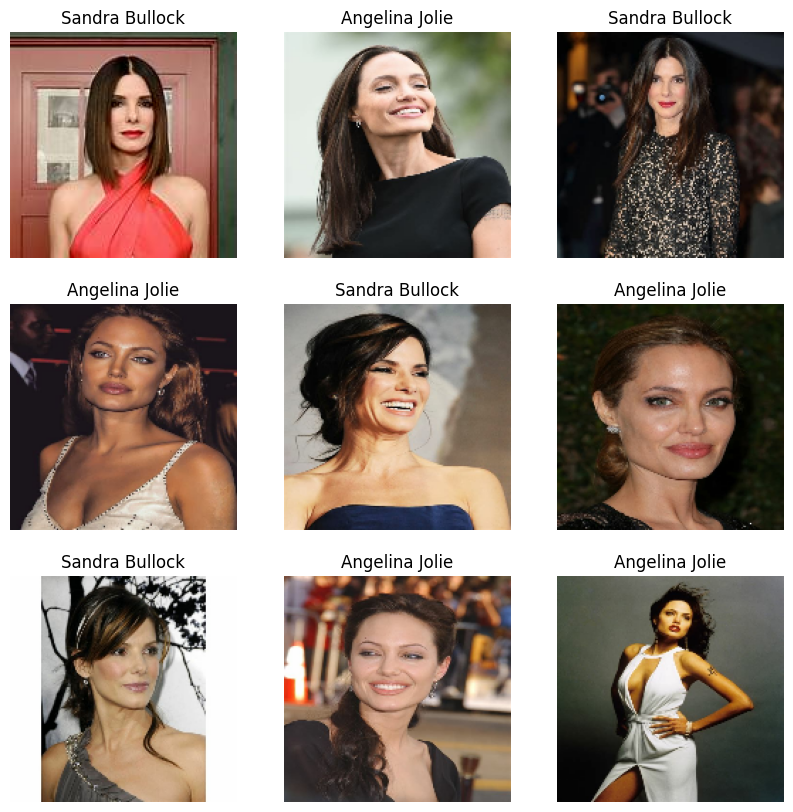

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 2
Number of test batches: 0


Introduzindo artificialmente a diversidade de amostras aplicando transformações aleatórias, mas realistas, às imagens de treinamento, como rotação e inversão horizontal. Isso ajuda a expor o modelo a diferentes aspectos dos dados de treinamento e a reduzir o sobreajuste

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

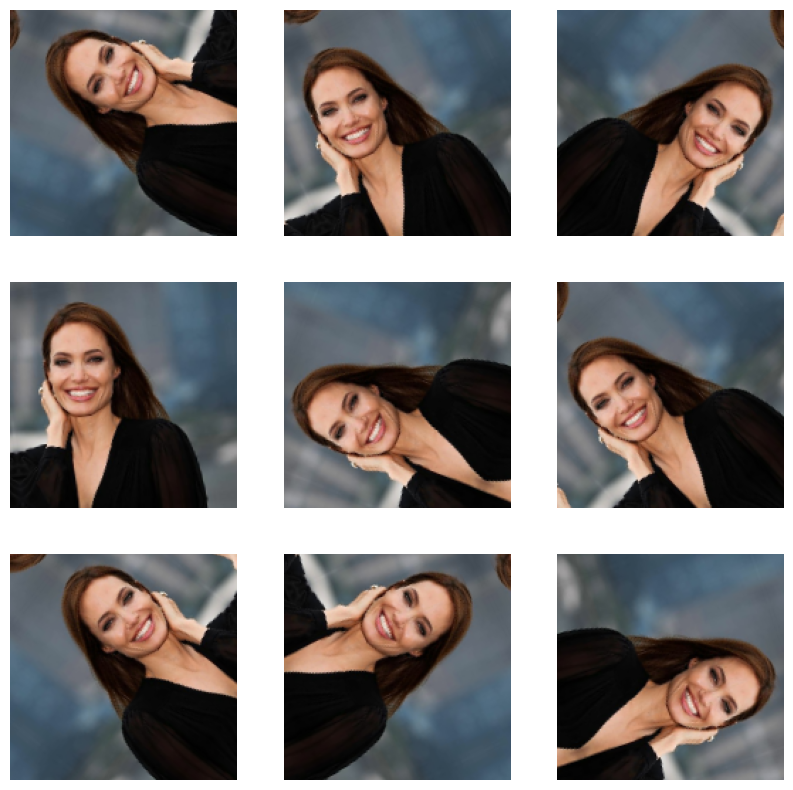

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Redimensionando os valores de pixel para o modelo que irá ser importado

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

# IMPORTANDO MODELO BASE E DEFININDO PARAMETROS DE TREINAMENTO

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = keras.applications.Xception(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet')  # Do not include the ImageNet classifier at the top.

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


Congelando a base convolucional antes de compilar e treinar o modelo. O congelamento (definindo layer.trainable = False) evita que os pesos de uma determinada camada sejam atualizados durante o treinamento.

In [ ]:
base_model.trainable = False

Para gerar previsões a partir do bloco de recursos, faça a média das 5x5localizações espaciais espaciais, usando uma tf.keras.layers.GlobalAveragePooling2Dcamada para converter os recursos em um único vetor de 1280 elementos por imagem.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


Criando um modelo encadeando as base_modelcamadas de aumento de dados, redimensionamento e extrindo recursos usando a API Keras Functional .

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

COMPILANDO O MODELO

In [ ]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

2/2 [==============================] - 8s 4s/step - loss: 0.6694 - binary_accuracy: 0.5167


# TREINAMENTO

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
5/5 [==============================] - 30s 5s/step - loss: 0.6916 - accuracy: 0.5429 - val_loss: 0.6373 - val_accuracy: 0.5833
Epoch 2/10
5/5 [==============================] - 24s 5s/step - loss: 0.6941 - accuracy: 0.5500 - val_loss: 0.6350 - val_accuracy: 0.5833
Epoch 3/10
5/5 [==============================] - 20s 4s/step - loss: 0.6642 - accuracy: 0.5643 - val_loss: 0.6326 - val_accuracy: 0.5833
Epoch 4/10
5/5 [==============================] - 24s 5s/step - loss: 0.6467 - accuracy: 0.6429 - val_loss: 0.6306 - val_accuracy: 0.5833
Epoch 5/10
5/5 [==============================] - 24s 5s/step - loss: 0.6680 - accuracy: 0.5786 - val_loss: 0.6292 - val_accuracy: 0.5833
Epoch 6/10
5/5 [==============================] - 24s 5s/step - loss: 0.6190 - accuracy: 0.6214 - val_loss: 0.6276 - val_accuracy: 0.5833
Epoch 7/10
5/5 [==============================] - 20s 4s/step - loss: 0.6408 - accuracy: 0.5857 - val_loss: 0.6263 - val_accuracy: 0.5833
Epoch 8/10
5/5 [==================

#  RESULTADOS

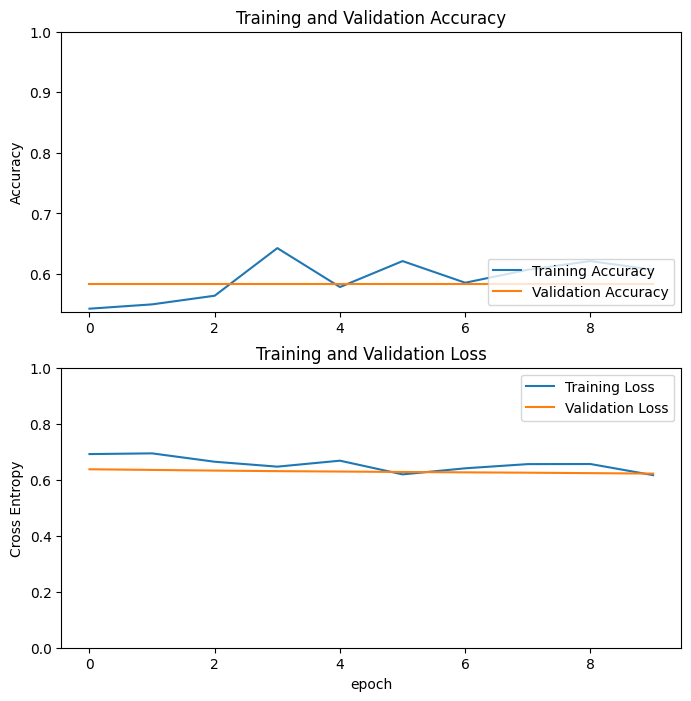

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# *FINE-TUNING*

No experimento de extração de recursos, você treinou apenas algumas camadas sobre um modelo base MobileNetV2. Os pesos da rede pré-treinada não foram atualizados durante o treinamento.

Uma maneira de aumentar ainda mais o desempenho é treinar (ou "ajustar") os pesos das camadas superiores do modelo pré-treinado junto com o treinamento do classificador que você adicionou. O processo de treinamento forçará os pesos a serem ajustados de mapas de recursos genéricos para recursos associados especificamente ao conjunto de dados.

Nota: Isso só deve ser tentado depois de você ter treinado o classificador de nível superior com o modelo pré-treinado definido como não treinável. Se você adicionar um classificador inicializado aleatoriamente em cima de um modelo pré-treinado e tentar treinar todas as camadas em conjunto, a magnitude das atualizações de gradiente será muito grande (devido aos pesos aleatórios do classificador) e seu modelo pré-treinado irá esqueça o que aprendeu.

Além disso, você deve tentar ajustar um pequeno número de camadas superiores em vez de todo o modelo MobileNet. Na maioria das redes convolucionais, quanto mais alta uma camada, mais especializada ela é. As primeiras camadas aprendem recursos muito simples e genéricos que se generalizam para quase todos os tipos de imagens. À medida que você avança, os recursos são cada vez mais específicos do conjunto de dados no qual o modelo foi treinado. O objetivo do ajuste fino é adaptar esses recursos especializados para funcionarem com o novo conjunto de dados, em vez de substituir o aprendizado genérico.

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']



plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()